In [2]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [13]:
DATA_PATH = './data/splitlabel/'
IMAGE_PATH = './data/467case_cut-20190916T015832Z-001/'
os.listdir(DATA_PATH)

['test_문-격자무늬 창.xlsx',
 'test_위치-집-아래.xlsx',
 'test_위치-집-정중앙.xlsx',
 'test_지면선-벽 밑면 있지만 지면 없음.xlsx',
 'test_지붕-그물무늬 음영.xlsx',
 'test_창문-격자무늬.xlsx',
 'test_창문-많다.xlsx',
 'test_창문-창문을 가린 커튼.xlsx',
 'train_문-격자무늬 창.xlsx',
 'train_위치-집-아래.xlsx',
 'train_위치-집-정중앙.xlsx',
 'train_지면선-벽 밑면 있지만 지면 없음.xlsx',
 'train_지붕-그물무늬 음영.xlsx',
 'train_창문-격자무늬.xlsx',
 'train_창문-많다.xlsx',
 'train_창문-창문을 가린 커튼.xlsx',
 '~$test_문-격자무늬 창.xlsx',
 '~$train_문-격자무늬 창.xlsx',
 '문-격자무늬 창.xlsx',
 '위치-집-아래.xlsx',
 '위치-집-정중앙.xlsx',
 '지면선-벽 밑면 있지만 지면 없음.xlsx',
 '지붕-그물무늬 음영.xlsx',
 '창문-격자무늬.xlsx',
 '창문-많다.xlsx',
 '창문-창문을 가린 커튼.xlsx']

In [14]:
house = ['문-격자무늬 창',
 '위치-집-아래',
 '위치-집-정중앙',
 '지면선-벽 밑면 있지만 지면 없음',
 '지붕-그물무늬 음영',
 '창문-격자무늬',
 '창문-많다',
 '창문-창문을 가린 커튼']

In [17]:
TRAIN_CROP_PATH = './train_crop'
TRAIN_IMG_PATH = os.path.join(IMAGE_PATH,'house')


df_train = []
df_test = []
for excel_name in house:
    df_train.append(pd.read_excel(os.path.join(DATA_PATH,'train_' + excel_name + '.xlsx')))
    df_train[house.index(excel_name)]['data'] = df_train[house.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    df_test.append(pd.read_excel(os.path.join(DATA_PATH,'test_' + excel_name + '.xlsx')))
    df_test[house.index(excel_name)]['data'] = df_test[house.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    
    

In [18]:
for i in range(len(house)):
    print(df_train[i].head(5))
    print(df_test[i].head(5))

   Unnamed: 0        data  문-격자무늬 창
0           6  0010_H.jpg         0
1         182  0351_H.jpg         0
2         170  0319_H.jpg         0
3         146  0272_H.jpg         0
4          30  0050_H.jpg         0
   Unnamed: 0        data  문-격자무늬 창
0         159  0300_H.jpg         0
1         264  0490_H.jpg         0
2         254  0476_H.jpg         0
3           9  0013_H.jpg         0
4          77  0129_H.jpg         0
   Unnamed: 0        data  위치-집-아래
0           6  0010_H.jpg        0
1         182  0351_H.jpg        1
2         170  0319_H.jpg        1
3         146  0272_H.jpg        0
4          30  0050_H.jpg        1
   Unnamed: 0        data  위치-집-아래
0         159  0300_H.jpg        1
1         264  0490_H.jpg        0
2         254  0476_H.jpg        0
3           9  0013_H.jpg        0
4          77  0129_H.jpg        0
   Unnamed: 0        data  위치-집-정중앙
0           6  0010_H.jpg         1
1         182  0351_H.jpg         0
2         170  0319_H.jpg         0
3   

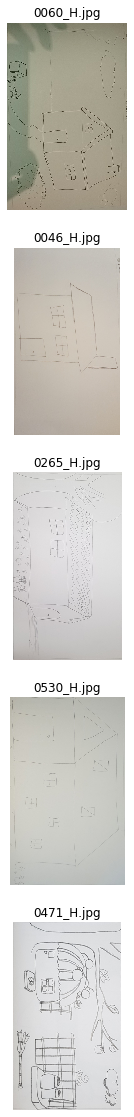

In [19]:
tmp_imgs = df_train[0]['data'][100:105]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, 2*num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

In [20]:
from sklearn.model_selection import train_test_split

df_train[0][house[0]] = df_train[0][house[0]].astype('str')

df_train[0] = df_train[0][['data', house[0]]]
df_test[0] = df_test[0][['data']]

its = np.arange(df_train[0].shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train[0].iloc[train_idx, :]
X_val = df_train[0].iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_train[0].shape)

(190, 2)
(48, 2)
(238, 2)


In [21]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [23]:
img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_train[0])
epochs = 20
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory=TRAIN_IMG_PATH,
    x_col = 'data',
    y_col = house[0],
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_IMG_PATH,
    x_col='data',
    y_col=house[0],
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test[0],
    directory=TRAIN_IMG_PATH,
    x_col='data',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="data". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 189 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 60 validated image filenames.


In [24]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [25]:
mobileNetModel = MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(mobileNetModel)
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [26]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [27]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else : 
        return num_samples // batch_size

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_mobile_model_{val_acc:.2f}_{val_loss:.4f}.h5"

ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [ckpt]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

Epoch 1/20
5/6 [========================>.....] - ETA: 1:24 - loss: 1.6575 - acc: 0.093 - ETA: 58s - loss: 1.2448 - acc: 0.343 - ETA: 40s - loss: 0.9569 - acc: 0.50 - ETA: 25s - loss: 0.7519 - acc: 0.62 - ETA: 12s - loss: 0.6472 - acc: 0.6879
Epoch 00001: val_acc improved from -inf to 0.02083, saving model to my_mobile_model_0.02_13.0546.h5
6/6 [==============================] - 79s 13s/step - loss: 0.5954 - acc: 0.7302 - val_loss: 13.0546 - val_acc: 0.0208
Epoch 2/20
5/6 [========================>.....] - ETA: 56s - loss: 0.0639 - acc: 0.93 - ETA: 45s - loss: 0.0876 - acc: 0.95 - ETA: 33s - loss: 0.0778 - acc: 0.96 - ETA: 22s - loss: 0.0764 - acc: 0.96 - ETA: 11s - loss: 0.0641 - acc: 0.9745
Epoch 00002: val_acc improved from 0.02083 to 0.27083, saving model to my_mobile_model_0.27_2.0136.h5
6/6 [==============================] - 71s 12s/step - loss: 0.0764 - acc: 0.9683 - val_loss: 2.0136 - val_acc: 0.2708
Epoch 3/20
5/6 [========================>.....] - ETA: 58s - loss: 0.0060 - ac

Epoch 20/20
5/6 [========================>.....] - ETA: 1:06 - loss: 1.7553e-05 - acc: 1.000 - ETA: 52s - loss: 2.2722e-05 - acc: 1.000 - ETA: 38s - loss: 4.6998e-05 - acc: 1.00 - ETA: 25s - loss: 1.0147e-04 - acc: 1.00 - ETA: 12s - loss: 8.4792e-05 - acc: 1.0000
Epoch 00020: val_acc did not improve from 0.97917
6/6 [==============================] - 78s 13s/step - loss: 7.6413e-05 - acc: 1.0000 - val_loss: 0.3995 - val_acc: 0.9792


184

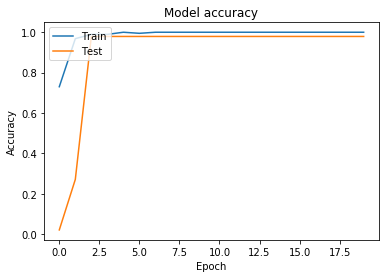

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

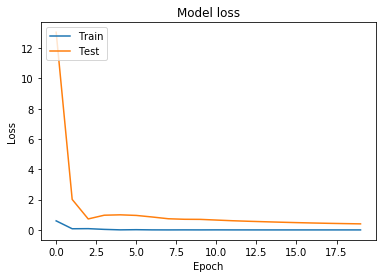

In [30]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [31]:
model_list = sorted([i for i in os.listdir() if "my_" in i])
model_list

['my_mobile_model_0.02_13.0546.h5',
 'my_mobile_model_0.27_2.0136.h5',
 'my_mobile_model_0.98_0.1496.h5',
 'my_mobile_model_0.98_0.7251.h5']

In [32]:
model.load_weights(model_list[-1])

In [33]:
test_generator.reset()
prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

8/8 [==============================] - ETA: 10 - ETA: 6 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 8s 941ms/step


In [ ]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head()